In [2]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [3]:
from masterthesis.data import load_h5ad

# load the python AnnData object
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/germ_sce.h5ad")
anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")

In [12]:
anndata.var.index.copy()

Index(['1/2-SBSRNA4', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2LD1', 'A2M', 'A2ML1',
       'A2MP1', 'A4GALT', 'A4GNT',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'tAKR'],
      dtype='object', length=23368)

In [9]:
anndata.var["FOO"] = 1
anndata.var

,primerid,FOO
1/2-SBSRNA4,1/2-SBSRNA4,1
A1BG,A1BG,1
A1BG-AS1,A1BG-AS1,1
A1CF,A1CF,1
A2LD1,A2LD1,1
...,...,...
ZYG11B,ZYG11B,1
ZYX,ZYX,1
ZZEF1,ZZEF1,1
ZZZ3,ZZZ3,1


In [8]:
# sampling in R with seed 1234
test_idx = [284, 336, 406, 101, 111, 393, 133, 400, 388, 98, 103, 214, 90, 326, 79, 372, 270, 382, 184, 62, 4, 403, 149, 40, 212, 195, 93, 122, 66, 175, 379, 304, 108, 131, 343, 41, 115, 228, 328, 298, 299]
train_idx = list(set(range(anndata.X.shape[0])) - set(test_idx))

# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

sel_genes = sorted(sel_genes)

from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in anndata.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(anndata[:,sel_genes].X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

# Less balanced classes in R!
#X_train, y_train = anndata[train_idx, sel_genes].X, y[train_idx]
#X_test, y_test = anndata[test_idx, sel_genes].X, y[test_idx]

print("Labels: ", k)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Labels:  8
(369, 26)
(42, 26)
(369,)
(42,)


In [9]:
X_train.shape

(369, 26)

# Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))

y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# reordering, such that yi < yi+1
train_reorder = np.argsort(y_train_trans)
test_reorder = np.argsort(y_test_trans)

# sample weighting
_, train_cts = np.unique(y_train_trans, return_counts=True)
_, test_cts = np.unique(y_test_trans, return_counts=True)

weights_train = [train_cts[el] / len(y_train_trans) for el in y_train_trans]
weights_test = [test_cts[el] / len(y_test_trans) for el in y_test_trans]

Text(0.5, 1.0, 'Targets Test Split')

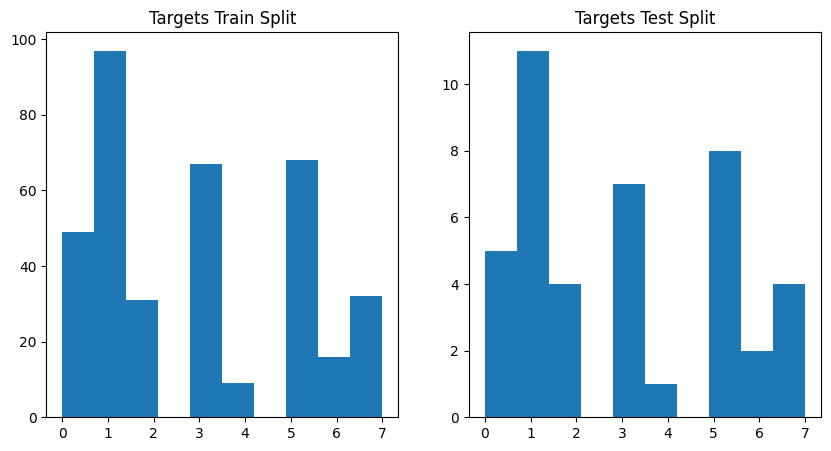

In [11]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(y_train_trans)
ax1.set_title("Targets Train Split")

ax2 = fig.add_subplot(122)
ax2.hist(y_test_trans)
ax2.set_title("Targets Test Split")

# Regularization

## Regularization Path

The regularization path is essential for the fit

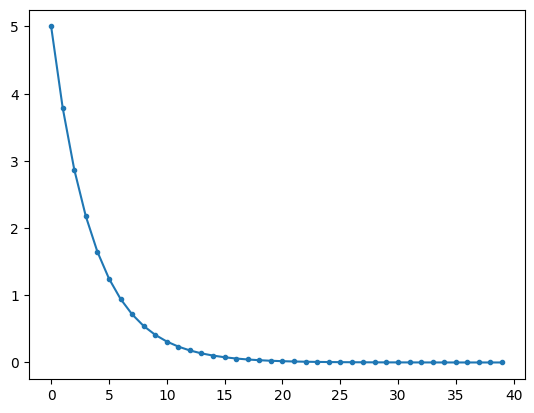

In [12]:
reg_params = np.geomspace(5, 0.0001, 40)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(reg_params, marker=".")
#ax.set_yscale("log")

## GirdSearchCV

In [ ]:
#from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, make_scorer
#from sklearn.model_selection import cross_validate, GridSearchCV
#from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
#from masterthesis.model import LinearBinarizedModel

#n_folds = 3
#kf = StratifiedKFold(n_splits=n_folds)

#scorers = {
#    "balanced_accuracy_score": make_scorer(metrics.balanced_accuracy_score),
#    "cross-entropy-loss": make_scorer(metrics.log_loss)
#}

#params = {"regularization": [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]}

#sk_binlogreg_model = LinearBinarizedModel(max_iter=10000, random_state=124)

#sk_binlogreg_cv = GridSearchCV(sk_binlogreg_model,
#                               param_grid=params,
#                               cv=kf.split(X_train, y_train_trans),
#                               scoring=make_scorer(metrics.balanced_accuracy_score),
#                               refit=True)

#sk_binlogreg_cv.fit(X_train, y_train_trans)

**There is no good way to track the sparsity (degrees of freedom) of the model with a GridSearchCV. This cannot be done via a scorer, as the respective estimator itself must be accessed. It cannot be done via a model attribute either, since only the parameter grid are saved, not all attributes of the class.** 

## Linear Model

Best idx: 8 Best Score: 0.4796747967479675 Best Lambda: 0.543348811445542 Scores std: 0.005992776256773979
1SE idx: 8 1SE Score: 0.4796747967479675 1SE Lambda: 0.543348811445542


Text(0.5, 0.98, 'Linear binarized Model training')

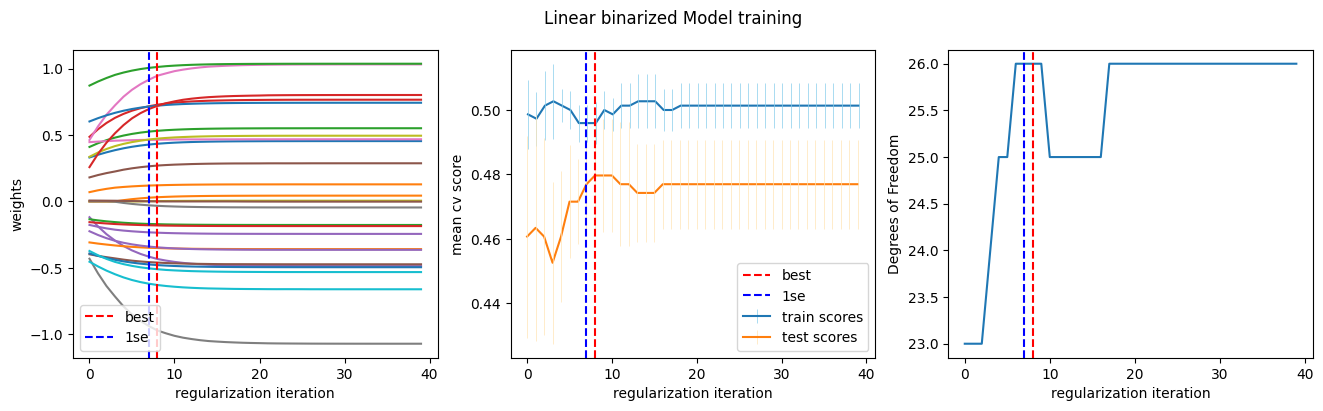

In [13]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import LinearBinarizedModel, SGDBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, make_scorer, mean_absolute_error

unique, counts = np.unique(y_train_trans, return_counts=True)

scoring = make_scorer(metrics.accuracy_score)
fit_params = {"sample_weight": None}
estimator_params = {"max_iter": 20000}

lin = RegularizationGridSearch(estimator=LinearBinarizedModel, n_folds=3, lambdas=reg_params, scoring=scoring)
lin.fit(X_train, y_train_trans, fit_params=fit_params, estimator_params=estimator_params)

best_lambda, best_idx = lin.get_optimal_lambda("best")
print("Best idx:", best_idx, "Best Score:", lin.scores[best_idx], "Best Lambda:", lin.lambdas[best_idx], "Scores std:", np.std(lin.scores))
ose_lambda, ose_idx = lin.get_optimal_lambda("1se")
print("1SE idx:", best_idx, "1SE Score:", lin.scores[best_idx], "1SE Lambda:", lin.lambdas[best_idx])

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(131)
fitted_weights = np.array([e.coef_ for e in lin.fitted_estimators])
ax1.plot(fitted_weights)
ax1.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax1.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax1.set_xlabel("regularization iteration")
ax1.set_ylabel("weights")
#ax1.set_yscale("log")
ax1.legend()

ax3 = fig.add_subplot(132)
ax3.errorbar(x=np.arange(len(lin.train_scores))+0.1, y=lin.train_scores, yerr=lin.train_scores_std, elinewidth=0.5, color="tab:blue", ecolor="skyblue", barsabove=True, label="train scores")
ax3.errorbar(x=np.arange(len(lin.scores)), y=lin.scores, yerr=lin.scores_std, elinewidth=0.5, color="tab:orange", ecolor="moccasin", barsabove=True, label="test scores")
ax3.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax3.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax3.set_xlabel("regularization iteration")
ax3.set_ylabel("mean cv score")
ax3.legend()

ax2 = fig.add_subplot(133)
ax2.plot(lin.dof)
ax2.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax2.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax2.set_xlabel("regularization iteration")
ax2.set_ylabel("Degrees of Freedom")

fig.suptitle("Linear binarized Model training")

Degrees of freedom 24
Train:
Accuracy: 0.5040650406504065
Balanced accuracy: 0.36422620936164896
Mean absolute delta: 0.8345450634545064
Test:
Accuracy: 0.4523809523809524
Balanced accuracy: 0.3295048701298701
Mean absolute delta: 1.1148648648648647


Text(0.5, 0.98, 'Linear Binarized Model (best cv-score)')

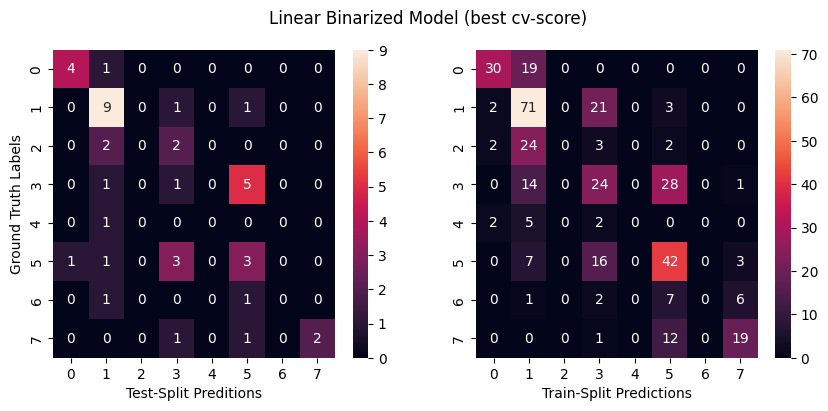

In [14]:
import seaborn as sns
from masterthesis.metrics import abs_delta
from sklearn.metrics import confusion_matrix

# retrain the best model on all training data
lin_model = lin.get_optimal_model("1se")
lin_model.fit(X_train, y_train_trans, sample_weight=None)

print("Degrees of freedom", len(np.nonzero(lin_model.coef_)[0]))
print("Train:")
print("Accuracy:", metrics.accuracy_score(y_train_trans, lin_model.predict(X_train)))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_train_trans, lin_model.predict(X_train)))
print("Mean absolute delta:", metrics.mean_absolute_error(y_train_trans, lin_model.predict(X_train), sample_weight=weights_train))
print("Test:")
print("Accuracy:", metrics.accuracy_score(y_test_trans, lin_model.predict(X_test)))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_trans, lin_model.predict(X_test)))
print("Mean absolute delta:", metrics.mean_absolute_error(y_test_trans, lin_model.predict(X_test), sample_weight=weights_test))

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(confusion_matrix(y_test_trans, lin_model.predict(X_test)), annot=True, ax=ax1)
sns.heatmap(confusion_matrix(y_train_trans, lin_model.predict(X_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")

fig.suptitle("Linear Binarized Model (best cv-score)")

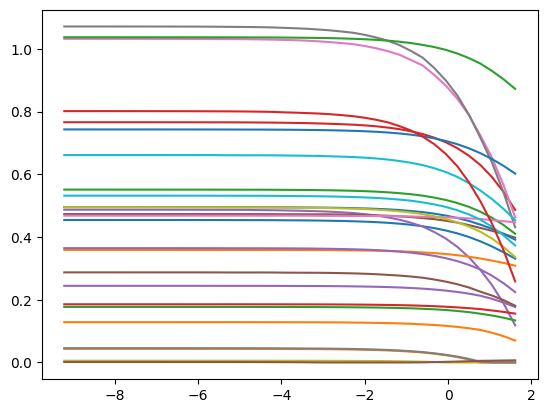

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log(lin.lambdas), np.abs(fitted_weights));

## SGD Model


Best idx: 35 Best Score: 0.4525360977415772 Best Lambda: 0.0003033511470543335 Scores std: 0.13498260345462154
1SE idx: 35 1SE Score: 0.4525360977415772 1SE Lambda: 0.0003033511470543335


Text(0.5, 0.98, 'SGD Model (best cv-score)')

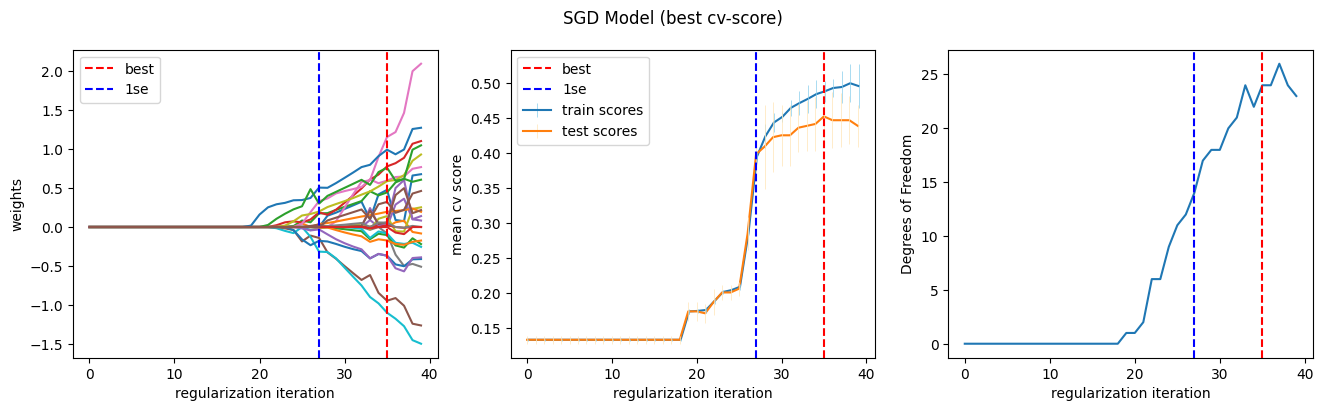

In [16]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import SGDBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = {"max_iter": 20}

sgd = RegularizationGridSearch(estimator=SGDBinarizedModel, n_folds=5, lambdas=reg_params, scoring=scoring)
sgd.fit(X_train, y_train_trans, fit_params=fit_params, estimator_params=estimator_params)

best_lambda, best_idx = sgd.get_optimal_lambda("best")
print("Best idx:", best_idx, "Best Score:", sgd.scores[best_idx], "Best Lambda:", sgd.lambdas[best_idx], "Scores std:", np.std(sgd.scores))
ose_lambda, ose_idx = sgd.get_optimal_lambda("1se")
print("1SE idx:", best_idx, "1SE Score:", sgd.scores[best_idx], "1SE Lambda:", sgd.lambdas[best_idx])

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(131)
fitted_weights = np.array([e.coef_ for e in sgd.fitted_estimators])
ax1.plot(fitted_weights)
ax1.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax1.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax1.set_xlabel("regularization iteration")
ax1.set_ylabel("weights")
#ax1.set_yscale("log")
ax1.legend()

ax3 = fig.add_subplot(132)
ax3.errorbar(x=np.arange(len(sgd.train_scores))+0.1, y=sgd.train_scores, yerr=sgd.train_scores_std, elinewidth=-0.5, color="tab:blue", ecolor="skyblue", barsabove=True, label="train scores")
ax3.errorbar(x=np.arange(len(sgd.scores)), y=sgd.scores, yerr=sgd.scores_std, elinewidth=0.5, color="tab:orange", ecolor="moccasin", barsabove=True, label="test scores")
ax3.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax3.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax3.set_xlabel("regularization iteration")
ax3.set_ylabel("mean cv score")
ax3.legend()

ax2 = fig.add_subplot(133)
ax2.plot(sgd.dof)
ax2.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax2.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax2.set_xlabel("regularization iteration")
ax2.set_ylabel("Degrees of Freedom")

fig.suptitle("SGD Model (best cv-score)")

In [17]:
idx = np.nonzero(sgd.dof)
print("max:", np.max(np.array(sgd.scores)))
print("std:", np.std(np.array(sgd.scores)[idx]))
thresh =  np.max(np.array(sgd.scores)) - (0.2* np.std(np.array(sgd.scores)[idx]))

for i, (s, d) in enumerate(zip(sgd.scores, sgd.dof)):
                # exclude models with 0 degrees of freedom
                if s > thresh and d != 0:
                    print (sgd.lambdas[i], sgd.dof[i], sgd.scores[i], i)
                    break

max: 0.4525360977415772
std: 0.11611017065787921
0.0006972762494645748 21 0.4363939281747501 32


Degrees of freedom 15
Train:
Cross Entropy: 5.171590616103521
Accuracy: 0.4010840108401084
Balanced accuracy: 0.3000221029133303
Mean abosolute delta: 1.2537319853731985
Test:
Cross Entropy: 5.615067869722464
Accuracy: 0.4523809523809524
Balanced accuracy: 0.328125
Mean absolute delta: 1.6216216216216215



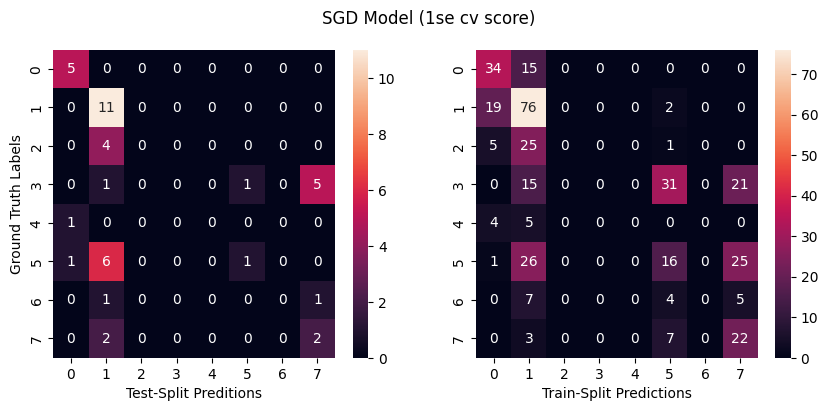

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

regularization_selected = "1se"
# retrain the best model on all training data
sgd_model = sgd.get_optimal_model(regularization_selected)
sgd_model.fit(X_train, y_train_trans, sample_weight=weights_train)

print("Degrees of freedom", len(np.nonzero(sgd_model.coef_)[0]))
print("Train:")
print("Cross Entropy:", metrics.log_loss(y_train_trans, sgd_model.predict_proba(X_train), labels=np.unique(y_train_trans)))
print("Accuracy:", metrics.accuracy_score(y_train_trans, sgd_model.predict(X_train)))
print("Balanced accuracy:", balanced_accuracy_score(y_train_trans, sgd_model.predict(X_train)))
print("Mean abosolute delta:", metrics.mean_absolute_error(y_train_trans, sgd_model.predict(X_train), sample_weight=weights_train))
print("Test:")
print("Cross Entropy:", metrics.log_loss(y_test_trans, sgd_model.predict_proba(X_test), labels=np.unique(y_test_trans)))
print("Accuracy:", metrics.accuracy_score(y_test_trans, sgd_model.predict(X_test)))
print("Balanced accuracy:", balanced_accuracy_score(y_test_trans, sgd_model.predict(X_test)))
print("Mean absolute delta:", metrics.mean_absolute_error(y_test_trans, sgd_model.predict(X_test), sample_weight=weights_test))

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(confusion_matrix(y_test_trans, sgd_model.predict(X_test)), annot=True, ax=ax1)
sns.heatmap(confusion_matrix(y_train_trans, sgd_model.predict(X_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")

fig.suptitle("SGD Model (%s cv score)" % regularization_selected)
print()

Why is the Accuracy so low?
Check the underlying binary predictions:

In [19]:
sgd_model.intercept_

array([ 1.59458072,  0.        ,  0.        , -0.62096313, -0.59766398,
       -1.81324615, -1.93443555])

In [20]:
bin_model = sgd_model.binary_estimator_
print(bin_model.score(sgd_model.restructure_X_to_bin(X_test, n_thresholds=sgd_model.k), sgd_model.restructure_y_to_bin(y_test)))
print(metrics.log_loss(
    sgd_model.restructure_y_to_bin(y_test),
    sgd_model.binary_estimator_.predict_proba(sgd_model.restructure_X_to_bin(X_test, n_thresholds=sgd_model.k))))

0.7891156462585034
0.4592704564357855


## Ordered Model Statsmodels

OrderedModel does not allow for regularization at all, so sparsity cannot be achieved

In [ ]:
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel


sm_model = OrderedModel(y_train_trans,
                        X_train,
                        distr='logit')

sm_model = sm_model.fit(method='bfgs')

sm_test_pred = np.apply_along_axis(np.argmax, 1, sm_model.model.predict(sm_model.params, exog=X_test))
sm_train_pred = np.apply_along_axis(np.argmax, 1, sm_model.model.predict(sm_model.params, exog=X_train))

print("Train:")
print("Balanced accuracy:", balanced_accuracy_score(y_train_trans, sm_train_pred))
print("Mean delta:", abs_delta(y_train_trans, sm_train_pred))
print("Test:")
print("Balanced accuracy:", balanced_accuracy_score(y_test_trans, sm_test_pred))
print("Mean delta:", abs_delta(y_test_trans, sm_test_pred))

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(confusion_matrix(y_test_trans, sm_test_pred), annot=True, ax=ax1)
sns.heatmap(confusion_matrix(y_train_trans, sm_train_pred), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")
print()

In [ ]:
from sklearn.linear_model import LogisticRegression

mn_model = LogisticRegression(multi_class="multinomial", # "auto", "ovr", "multinomial"
                              solver="saga",
                              random_state=1234)

mn_model.fit(X_train, y_train)


print("Degrees of freedom", len(np.nonzero(mn_model.coef_)[0]))
print("Train:")
print("Cross Entropy:", metrics.log_loss(y_train_trans, mn_model.predict_proba(X_train), labels=np.unique(y_train_trans)))
print("Accuracy:", metrics.accuracy_score(y_train_trans, mn_model.predict(X_train)))
print("Balanced accuracy:", balanced_accuracy_score(y_train_trans, mn_model.predict(X_train)))
print("Mean abosolute delta:", metrics.mean_absolute_error(y_train_trans, mn_model.predict(X_train), sample_weight=weights_train))
print("Test:")
print("Cross Entropy:", metrics.log_loss(y_test_trans, mn_model.predict_proba(X_test), labels=np.unique(y_test_trans)))
print("Accuracy:", metrics.accuracy_score(y_test_trans, mn_model.predict(X_test)))
print("Balanced accuracy:", balanced_accuracy_score(y_test_trans, mn_model.predict(X_test)))
print("Mean absolute delta:", metrics.mean_absolute_error(y_test_trans, mn_model.predict(X_test), sample_weight=weights_test))

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(confusion_matrix(y_test_trans, mn_model.predict(X_test)), annot=True, ax=ax1)
sns.heatmap(confusion_matrix(y_train_trans, mn_model.predict(X_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")

fig.suptitle("Multinomial Model ")
print()

## Predictions from R Model

In [ ]:
from masterthesis.model import LinearBinarizedModel

# best model at index 30
a0_best = -2.227060
beta_best = [0.49868652,  0.00000000,  0.80094071,  1.10784599,  0.00000000,
 -1.22080633,  2.13832900,  0.00000000,  0.07703369, -0.87913515,
-0.69016970, -0.09897009, -0.36847006, 0.00000000,  0.00000000,
  0.00000000,  0.31711026,  0.00000000 , 0.30262339, -0.53867811,
 0.52152742, -0.44893630,  0.96068236,  0.24511039, -1.01364007,
  0.23483288] 
theta_best = np.array([5.92396782,  2.89065156,  2.30399098 , 0.99301782,
 0.80932371 ,-1.27222906 ,-2.08211032]) + a0_best


# sparse model at index 25
a0_sparse = -2.028611
beta_sparse = [0.43112830,  0.00000000,  0.64826864,  0.73782956,  0.00000000, -1.04226366,  1.54177642,  0.00000000,
  0.06308442, -0.41784907, -0.63786260, -0.03616000, -0.33776577,  0.00000000,  0.00000000,  0.00000000,
  0.35427156,  0.00000000,  0.26779114, -0.39372263,  0.57375136, -0.50845432,  1.00594368,  0.04929092,
 -0.84410460,  0.22600665]
theta_sparse = np.array([ -3.50504731, -0.63172557, -0.06603429,  1.18670519,  1.36056660,  3.29628842,  4.03055833])[::-1] + -2.028611

r_model = LinearBinarizedModel()
r_model.coef_ = beta_sparse #beta_best
r_model.intercept_ = theta_sparse #theta_best
r_model.is_fitted_ = True
r_model.k = 7

print(r_model.predict(X_test))
print(y_test_trans)

print("Degrees of freedom", len(np.nonzero(beta_sparse)[0]))
print("Train:")
print("Balanced accuracy:", balanced_accuracy_score(y_train_trans, r_model.predict(X_train)))
print("Mean delta:", metrics.mean_absolute_error(y_train_trans, r_model.predict(X_train), sample_weight=weights_train))
print("Test:")
print("Balanced accuracy:", balanced_accuracy_score(y_test_trans, r_model.predict(X_test)))
print("Mean delta:", metrics.mean_absolute_error(y_test_trans, r_model.predict(X_test), sample_weight=weights_test))

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(confusion_matrix(y_test_trans, r_model.predict(X_test)), annot=True, ax=ax1)
sns.heatmap(confusion_matrix(y_train_trans, r_model.predict(X_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")
fig.suptitle("R model (best cv fit)")
print()

**Best results when using weights for training and balanced_accuracy for scoring. But then, the 1se model only calls two of the target classes.**

# Benchmark Classification

In [ ]:
from scanpy import datasets
from sklearn.model_selection import train_test_split


ds = datasets.blobs()
y = np.array([int(x) for x in ds.obs.blobs])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(ds.X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))

y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# sample weighting
_, train_cts = np.unique(y_train_trans, return_counts=True)
_, test_cts = np.unique(y_test_trans, return_counts=True)

weights_train = [train_cts[el] / len(y_train_trans) for el in y_train_trans]
weights_test = [test_cts[el] / len(y_test_trans) for el in y_test_trans]

In [ ]:
cv = RegularizationGridSearch(SGDBinarizedModel).fit(X_train, y_train_trans)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# retrain the best model on all training data
sgd_bm_model = sgd.get_optimal_model("1se")
sgd_bm_model.fit(X_train, y_train_trans, sample_weight=weights_train)


print("Train:")
print("Cross Entropy:", metrics.log_loss(y_train_trans, sgd_bm_model.predict_proba(X_train), labels=np.unique(y_train_trans)))
print("Accuracy:", metrics.accuracy_score(y_train_trans, sgd_bm_model.predict(X_train)))
print("Balanced accuracy:", balanced_accuracy_score(y_train_trans, sgd_bm_model.predict(X_train)))
print("Mean abosolute delta:", metrics.mean_absolute_error(y_train_trans, sgd_bm_model.predict(X_train), sample_weight=weights_train))
print("Test:")
print("Cross Entropy:", metrics.log_loss(y_test_trans, sgd_bm_model.predict_proba(X_test), labels=np.unique(y_test_trans)))
print("Accuracy:", metrics.accuracy_score(y_test_trans, sgd_bm_model.predict(X_test)))
print("Balanced accuracy:", balanced_accuracy_score(y_test_trans, sgd_bm_model.predict(X_test)))
print("Mean absolute delta:", metrics.mean_absolute_error(y_test_trans, sgd_bm_model.predict(X_test), sample_weight=weights_test))

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(confusion_matrix(y_test_trans, sgd_bm_model.predict(X_test)), annot=True, ax=ax1)
sns.heatmap(confusion_matrix(y_train_trans, sgd_bm_model.predict(X_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")

fig.suptitle("SGD Model (best cv score)")
print()

# Memory usage

In [ ]:
import sys

print("X:", sys.getsizeof(anndata) / 1000000)
print("gs:", sys.getsizeof(cv) / 1000000)

In [ ]:
a = np.array([1,2,3, np.exp(709), np.exp(710)])
a[np.isinf(a)]